In [3]:
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import random
from scipy.signal import windows,freqz
from scipy import signal, fft
%run Functions.ipynb

In [2]:
length = 500
bandwidth = 4/length
K = 7
wins, eigvals = windows.dpss(M = length, NW = bandwidth*length, Kmax = K, return_ratios=True)
print(eigvals)

[1.         0.99999997 0.99999879 0.99996759 0.99941051 0.99250788
 0.93666555]


In [21]:
noise = Noise(length, 'Lomax')
gridSize = int(length**(1.5)*math.log(length)/np.log(10))
amp = 0
sigma_max = 1
y = noise.AR([0.75, -0.5, 0, 0])

Mean of Stationary Process: 0.0


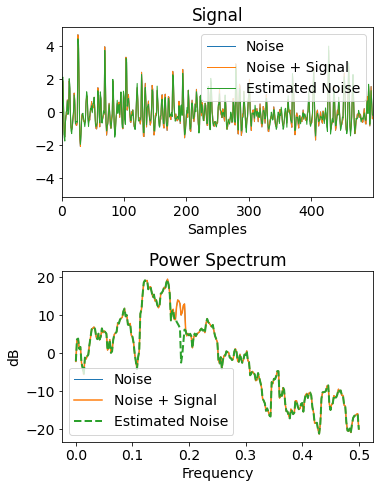

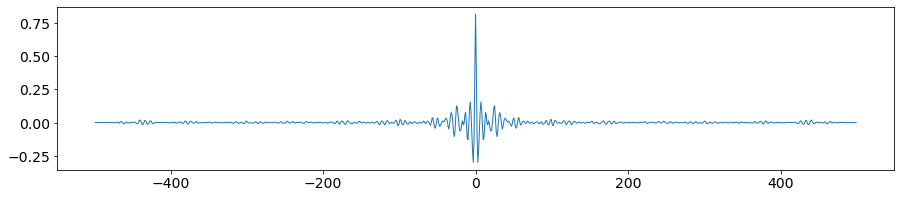

In [27]:
signalSample = y.copy()-np.mean(y)

fig, ax = plt.subplots(2, figsize = (5.5,7))
ax[0].plot(signalSample, linewidth=1.)

avgSdf = np.zeros(int(length/2)+1)
for i in range(len(wins)):
    temp, sdfWin = signal.periodogram(signalSample, window = wins[i])
    avgSdf = avgSdf + sdfWin
avgSdf /= len(wins)
ax[1].plot(temp, 20*np.log10(avgSdf), linewidth= 1,)

signalSample = np.array(signalSample)
print("Mean of Stationary Process:", np.average(signalSample))
signalSample -= np.average(signalSample)

max_fstat, argmax_freq, argmax_mult = get_waveShapeFStat_unknownL(signalSample, gridSize, bandwidth, 1/2-bandwidth, sigma_max, 4)
ax[0].plot(signalSample, linewidth=1.)
ax[0].set(xlim=[0, length-1], ylim=[-1.1*max(signalSample), 1.1*max(signalSample)], xlabel='Samples',
       title='Signal')

avgSdf = np.zeros(int(length/2)+1)
for i in range(len(wins)):
    temp, sdfWin = signal.periodogram(signalSample, window = wins[i])
    avgSdf = avgSdf + sdfWin
avgSdf /= len(wins)

ax[1].plot(temp, 20*np.log10(avgSdf), linewidth= 1.5)
ax[1].set(title='Power Spectrum')

"""Remove wave periodic component and recompute acvs"""
signalSample = remove_waveShape(signalSample, wins, argmax_freq, argmax_mult)
ax[0].plot(signalSample, linewidth=1)

avgSdf = np.zeros(int(length/2)+1)
for i in range(len(wins)):
    temp, sdfWin = signal.periodogram(signalSample, window = wins[i])
    avgSdf = avgSdf + sdfWin
avgSdf /= len(wins)
ax[1].plot(temp, 20*np.log10(avgSdf), '--', linewidth= 2)

ax[0].legend(['Noise', 'Noise + Signal', 'Estimated Noise'])
ax[1].legend(['Noise', 'Noise + Signal', 'Estimated Noise'])
ax[1].set_ylabel('dB')
ax[1].set_xlabel('Frequency')
fig.tight_layout()
plt.show()

"""Estimate autocovariance sequence via DPSS"""
thres = length**(1/3)
acvs_est = []
for i in range(-length+1,length):
    total = 0
    for j in range(max(-i,0),min(length-i,length)):
        coeff = 0
        for win in wins:
            coeff += win[j]*win[j+i]
        total += coeff*signalSample[j]*signalSample[j+i]/len(wins)
    acvs_est.append(total)
fig, ax = plt.subplots(1, figsize=(15, 3))
ax.plot(range(-length+1,length), acvs_est, linewidth=1)
plt.show()    

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:59<00:00, 23.84it/s]


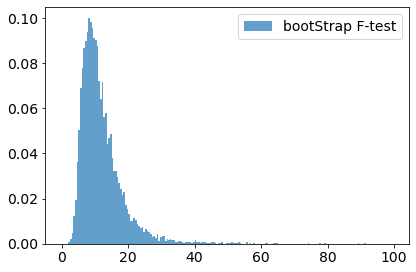

In [28]:
covarianceMatrix = []
for i in range(length):
    row_i = []
    for j in range(length):
        row_i.append(acvs_est[i-j+length-1])
    covarianceMatrix.append(row_i)
covarianceMatrix = np.array(covarianceMatrix)
# print(covarianceMatrix, np.linalg.matrix_rank(covarianceMatrix))
choleskyDecomp = np.linalg.cholesky(covarianceMatrix)

samples = []
num_simulations = 10000
from tqdm import tqdm
for t in tqdm(range(num_simulations)):
    gaussianInnovations = np.random.normal(0,1,length)
    btSignalSample = np.matmul(choleskyDecomp,np.transpose(gaussianInnovations))
    max_fstat, argmax_freq, argmax_mult = get_waveShapeFStat_unknownL(btSignalSample, gridSize, bandwidth, 1/2-bandwidth, sigma_max, 4)
    samples.append(max_fstat)
samples.sort(reverse=True)
fig, ax = plt.subplots()
scale = 100
bins = np.arange(0, scale, scale/200)
ax.hist(samples, bins, density = True, label = 'bootStrap F-test', alpha = 0.7)
ax.legend()
fig.tight_layout()
plt.show()    

In [35]:
kolmogorovDist = []
for a in tqdm(range(100)):
    stat_vals = []

    from tqdm import tqdm
    for sim in range(10000):
        noise = Noise(length, 'Lomax')
        y = noise.AR([0.75, -0.5, 0, 0])
        signalSample = y.copy()-np.mean(y)
        signalSample = np.array(signalSample)
        signalSample -= np.average(signalSample)

        max_fstat, argmax_freq, argmax_mult = get_waveShapeFStat_unknownL(signalSample, gridSize, bandwidth, 1/2-bandwidth, sigma_max, 4)
        stat_vals.append(max_fstat)
    kolmogorovDist.append(st.ks_2samp(stat_vals,samples)[0])

  0%|                                                                                          | 0/100 [00:33<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
np.mean(kolmogorovDist)

In [ ]:
fig, ax = plt.subplots()
scale = 100
bins = np.arange(0, scale, scale/200)
ax.hist(stat_vals, bins, density = True, label = 'True Distribution', alpha = 1)
ax.hist(samples, bins, density = True, label = 'Bootstrap Distribution', alpha = 0.6)
ax.legend()
ax.set_xlabel('Probability Density Function')
ax.set_ylabel('Density')
fig.tight_layout()
plt.show()    

In [ ]:
data_all = sorted(np.concatenate([stat_vals, samples]))
cdf1 = np.searchsorted(sorted(stat_vals), data_all, side='right') / len(stat_vals)
cdf2 = np.searchsorted(sorted(samples), data_all, side='right') / len(samples)
cddiffs = np.abs(cdf1 - cdf2)

plt.figure(figsize=(6, 4))
plt.plot(np.sort(stat_vals), np.linspace(0, 1, len(stat_vals), endpoint=False))
plt.plot(np.sort(samples), np.linspace(0, 1, len(samples), endpoint=False))
plt.plot(sorted(data_all), cddiffs, linestyle='--')
plt.xlabel('wave-shape $F$-statistic')
plt.ylabel('Cumulative Density Function')
plt.xlim([0,100])
plt.grid(linestyle = '--')
plt.rcParams['font.size'] = '14'
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.legend(['True Distribution','Bootstrap Distribution','Difference'])
plt.show()
print('Kolmogorov Distance: ',st.ks_2samp(stat_vals,samples)[0])

In [ ]:
plt.figure(figsize=(5.5, 4))
plt.scatter(np.sort(stat_vals), np.sort(samples), s=2)
plt.plot(np.linspace(0,130,700),np.linspace(0,130,700),'k', linestyle = '--') 
plt.xlabel('True Distribution')
plt.ylabel('Bootstrap Distribution')
plt.show() 